# Moped Fake Review Identification with Machine Learning #

## Data Validation ##

In [1]:
import pandas as pd

df = pd.read_csv('moped.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.tail(n=10))

# looking through .head() and .tail(n=20), missing values are indicated by NaN - fill with 0's
df_full = df.fillna(0)
print(df_full.info()) # make sure no NaN values remain

# add and map new column 'Owned' - 0 meaning never owned and 1 meaning owned
owned_dict = {
    '<= 6 months': 1, 
    '> 6 months': 1, 
    'Never owned': 0
}
df_full['Owned'] = df_full['Owned for'].map(owned_dict)
df_full = df_full.drop(['Owned for'],axis=1)

  Used it for    Owned for Model Name  Visual Appeal  Reliability  \
0   Commuting  Never owned  TVS iQube            3.0          4.0   
1     Leisure   > 6 months  TVS iQube            3.0          1.0   
2   Commuting  <= 6 months  TVS iQube            4.0          4.0   
3   Commuting   > 6 months  TVS iQube            1.0          1.0   
4   Commuting   > 6 months  TVS iQube            3.0          4.0   

   Extra Features  Comfort  Maintenance cost  Value for Money  
0             NaN      4.0               NaN              1.0  
1             NaN      3.0               NaN              3.0  
2             NaN      5.0               NaN              2.0  
3             NaN      1.0               NaN              1.0  
4             NaN      3.0               NaN              2.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0 

### Data Validation steps: ###

First ran some high-level summary methods on the dataframe to get familiar with it.

Seeing 4 columns had hundreds of NaN values, they were replaced with the value 0 (as instructed - though an argument could be made for replacing the NaN vlues with the column mean to avoid skew).

The dtypes of the columns were all appropriate - no changes necessary.

A dictionary depicting ownership with the values 0 or 1 was made to map a new column to those values, 'Owned' - we will use this as our label for later ML modeling.

Column labels are properly labeled -  no changes made to them.

All values had min values of 1 and max of 5 (excluding former NaN values) - no changes were made to those points.

## Exploratory Analysis ##

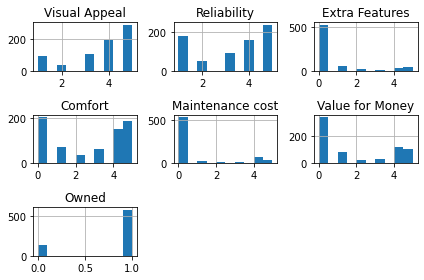

1    0.810659
0    0.189341
Name: Owned, dtype: float64


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Histograms
df_full.hist()
plt.tight_layout()
plt.show()
# visualizing the distribution of value counts across numeric features
# see that majority (81%) reported ownerhsip of moped
print(df_full['Owned'].value_counts(normalize=True))

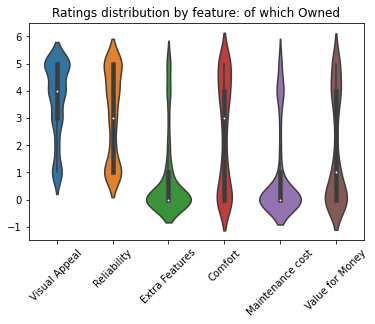

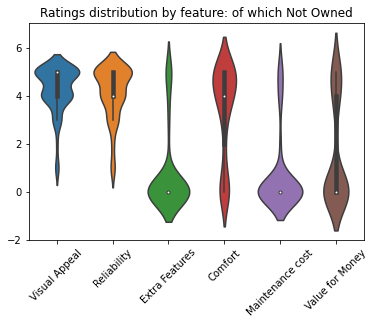

In [4]:
## Violin Plots
plot_owned = df_full[df_full['Owned'] == 1].drop('Owned', axis=1)
plot_not_owned= df_full[df_full['Owned'] == 0].drop('Owned', axis=1)

sns.violinplot(data=plot_owned).set(title='Ratings distribution by feature: of which Owned')
plt.xticks(rotation=45)
plt.show()

sns.violinplot(data=plot_not_owned).set(title='Ratings distribution by feature: of which Not Owned')
plt.xticks(rotation=45)
plt.show()

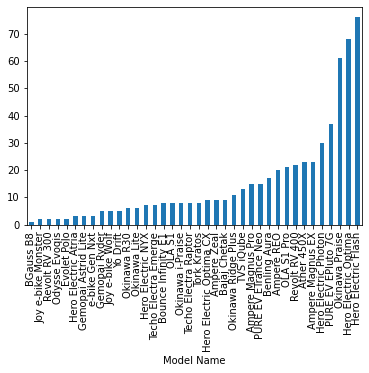

In [5]:
## Bar Plot
models = df_full.groupby('Model Name')['Owned'].sum().sort_values()
models.plot(kind='bar')
plt.show()
# shows model ownership

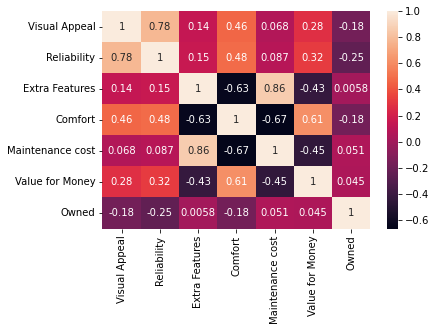

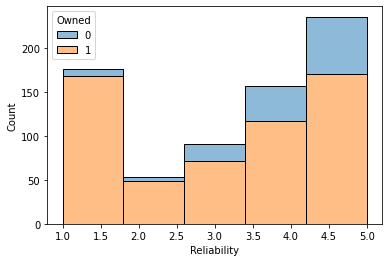

In [6]:
## Correlation Matrix
sns.heatmap(df_full.corr(), annot=True)
plt.show()

# looks like ownership is not strongly correlated with any 1 variable
# we can visualize the strongest relationship

## Histogram by ownership
sns.histplot(data=df_full, x='Reliability', bins=5, hue='Owned', multiple='stack', alpha=0.5)
plt.show()

In [7]:
# scaling not needed given values of 1 - 5, but given categories, need to get dummy variables for any ML model to run properly
df_ml = pd.get_dummies(df_full)
features = df_ml.drop(columns='Owned', axis=1).values
label = df_ml['Owned'].values

### Exploratory Analysis steps: ###

First we plot the histograms for 6 of the features and the 'Owned' label.
- We see that majority of the data includes those reporting they've owned a moped, which is 81%.
- We also see the impact our .fillna() method has on the distribution of some features, primarily the 'Extra Features' and 'Maintenance cost' columns, whose values are mostly 0.

Next we break down the distribution of the ratings of each feature by looking at some violin plots.
- The charts are telling. They confirm the skewness of the 'Extra Features' and 'Maintenance cost' columns given their medians of 0.
- They also show that those reporting 'Not Owned' have given much higher ratings for features 'Visual appeal' and 'Reliability'.

We take a look at the most popular models reviewers made.
- The top 3 were the Hero Electric Flash, Hero Electric Optima, and the Okinawa Praise.

The correlation heat map gives us a quick look to which variables exhibit relationships with eachother.
- No strong correlation exists among the 'Owned' column.
- We visualize the strongest related variable 'Reliability' by ownership and see that, to a small extent, the negative correlation is a result of non-owners reporting high reliability.
- One strong relationship among the matrix is Extra Features and Maintenance cost, indicating that reviewers tend to report high maintenance costs on the mopeds with extra features, giving us a little more confidence in the accuracy of the dataset.

The one change we made was run pd.get_dummies() on the dataset to convert the two features 'Used it for' and 'Model Name' into numeric data, necessary for running any ML model.

## Model Fitting ##

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Decision Tree fitting/predicting
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
dt = DecisionTreeClassifier()
dt.fit(X_train_dt, y_train_dt)
y_pred_dt = dt.predict(X_test_dt)


# Decision Tree optimizing
params = {'max_depth': np.arange(1,9)}
cv_dt = GridSearchCV(dt, param_grid=params)
cv_dt.fit(X_train_dt, y_train_dt)
y_pred_cv_dt = cv_dt.predict(X_test_dt)


# Logistic Regression fitting/predicting
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train_logit, y_train_logit)
y_pred_logit = logreg.predict(X_test_logit)

### Model Fitting steps: ###

We are working on a Classification problem.
- Given all the features available to us, we must make a decision as to whether the review comes from an actual owner of the moped or not
- This label is identified as 'Owned', whose column we created in the first part of the workbook.

The Decision Tree Classifier was chosen as the base model for this problem.
- It's a classification algorithm that essentially uses nested if-else statements through a root and nodes to come to a decision.
- It's also known to be better at drawing the decision boundary when there are outlier data, as we saw in our exploratory analysis.

The Logistic Regression model was chosen as the comparison model.
- It's also a classification algorithm, but draws the decision boundary more linearly, meaning it's less flexible in accounting for overlapping data points of the different labels.
- However, if there is not much overlap and the label could clearly be identified linearly, this model could prove to be the better classifier for this situation.

## Model Evaluation

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Decision Tree accuracy:', accuracy_score(y_test_dt, y_pred_dt).round(4))
print('Best Decision Tree params:', cv_dt.best_params_)
print('Decision Tree accuracy after Grid Search:', cv_dt.best_score_.round(4))

print('\nLogistic Regression accuracy:', accuracy_score(y_test_logit, y_pred_logit).round(4))

cm_dt = confusion_matrix(y_test_dt, y_pred_cv_dt)
cm_logit = confusion_matrix(y_test_logit, y_pred_logit)

print('\nDecision Tree Confusion Matrix: \n', cm_dt)
print('\nLogistic Regression Confusion Matrix: \n', cm_logit)

Decision Tree accuracy: 0.7944
Best Decision Tree params: {'max_depth': 1}
Decision Tree accuracy after Grid Search: 0.8397

Logistic Regression accuracy: 0.8318

Decision Tree Confusion Matrix: 
 [[  6  35]
 [  3 170]]

Logistic Regression Confusion Matrix: 
 [[  9  32]
 [  4 169]]


### Model Evaluation steps & conclusion: ###

The optimized Decision Tree model gave us a better accuracy score, meaning accurate predictions as a % of total predictions were higher than that of Logistic Regression.

However, when looking at which model to choose, it may be helpful in looking at the confusion matrix. Out of the 41 reviews that reported not owning their mopeds, the Decision Tree correctly predicted 6 of them. Whereas for the Logistic Regression model, it correctly predicted 9.

One could make the argument, which we will, that although the Decision Tree returned slightly more accurate results, the model that outputs the highest number of True Negatives, or lowest number of False Positives, is more likely to be the one we use in the real world.
This is because our focus is on identifying the number of false reviews, or the number of reviews that stated Ownership of a moped but has actually never owned one.